# Imports

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:
train_path = './data/train.csv'
test_path = './data/test.csv'

In [53]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [54]:
train_df.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [55]:
train_df.isna().sum()[train_df.isna().sum() > 0].sort_values(ascending=False)

Academic Pressure     112803
Study Satisfaction    112803
CGPA                  112802
Profession             36630
Work Pressure          27918
Job Satisfaction       27910
Dietary Habits             4
Financial Stress           4
Degree                     2
dtype: int64

# EDA

With the help of ChatGPT, we mapped **degrees** to **professions** to check if the **degrees** match the corresponding **professions**.

In [56]:
degree_to_profession = {
    'Chef': ['BHM', 'MHM'],
    'Teacher': ['BA', 'B.Ed', 'MA', 'M.Ed'],
    'Business Analyst': ['BBA', 'B.Com', 'MBA', 'M.Com'],
    'Financial Analyst': ['B.Com', 'M.Com'],
    'Finanancial Analyst': ['B.Com', 'M.Com'],
    'Chemist': ['B.Pharm', 'BSc', 'MPharm', 'MSc'],
    'Electrician': [],
    'Software Engineer': ['BE', 'B.Tech', 'BCA', 'MCA', 'M.Tech'],
    'Data Scientist': ['BSc', 'BCA', 'MSc', 'MCA', 'M.Tech'],
    'Plumber': ['Plumber'],
    'Marketing Manager': ['BHM', 'BBA', 'MBA', 'MHM'],
    'Accountant': ['B.Com', 'M.Com'],
    'Entrepreneur': ['BBA', 'MBA', 'B.Com', 'MHM'],
    'HR Manager': ['MBA'],
    'UX/UI Designer': ['BCA', 'MCA'],
    'Content Writer': ['BA', 'MA'],
    'Educational Consultant': ['BA', 'MA', 'B.Ed', 'M.Ed'],
    'Civil Engineer': ['BE', 'B.Tech', 'M.Tech'],
    'Manager': [],
    'Pharmacist': ['B.Pharm', 'M.Pharm'],
    'Financial Analyst': ['B.Com', 'M.Com'],
    'Architect': ['B.Arch', 'M.Arch'],
    'Mechanical Engineer': ['BE', 'B.Tech', 'M.Tech'],
    'Customer Support': [],
    'Consultant': [],
    'Judge': ['LLB', 'LLM'],
    'Researcher': ['PhD', 'MSc'],
    'Pilot': [],
    'Graphic Designer': [],
    'Travel Consultant': [],
    'Digital Marketer': [],
    'Lawyer': ['LLB', 'LLM'],
    'Research Analyst': ['BSc', 'MSc'],
    'Sales Executive': [],
    'Doctor': ['MD', 'MBBS'],
    'Unemployed': [],
    'Investment Banker': [],
    'Family Consultant': [],
    'B.Com': ['B.Com'],
    'BE': ['BE'],
    'Student': ['Class 12', 'B Student'],
    'Yogesh': [],
    'Dev': [],
    'MBA': ['MBA'],
    'LLM': ['LLM'],
    'BCA': ['BCA'],
    'Academic': [],
    'Profession': [],
    'FamilyVirar': [],
    'City Manager': [],
    'BBA': ['BBA'],
    'Medical Doctor': ['MD', 'MBBS'],
    'Working Professional': ['Working Professional'],
    'MBBS': ['MBBS'],
    'Patna': [],
    'Unveil': [],
    'B.Ed': ['B.Ed'],
    'Nagpur': [],
    'Moderate': [],
    'M.Ed': ['M.Ed'],
    'Analyst': [],
    'Pranav': [],
    'Visakhapatnam': [],
    'PhD': ['PhD'],
    'Yuvraj': []
}

def profession_degree_match(x):
  if pd.isna(x['Profession']):
    return 'Is Student' if x['Working Professional or Student'] == 'Student' else 'UNKNOWN'
  if x['Profession'] not in degree_to_profession.keys():
    return 'UNKNOWN'
  if len(degree_to_profession[x['Profession']]) == 0:
    return 'UNKNOWN'
  if x['Degree'] in degree_to_profession[x['Profession']]:
    return 'Matching'
  else:
    return 'Not Matching'

In [57]:
dietary_map = {
  'Healthy': 3,
  'Moderate': 2,
  'Unhealthy': 1,
}

In [58]:
train_df['Profession'].value_counts()

Profession
Teacher           24906
Content Writer     7814
Architect          4370
Consultant         4229
HR Manager         4022
                  ...  
BBA                   1
City Manager          1
FamilyVirar           1
B.Com                 1
Yuvraj                1
Name: count, Length: 64, dtype: int64

We created classification functions to categorize **study hours** and **CGPA** into meaningful labels or scales. This helps in analyzing patterns and relationships between these factors more effectively.

In [59]:
def study_hours_classification(x):
  if pd.isna(x):
    return 'Moderate'
  if x >= 6:
    return 'High'
  if x >= 3:
    return 'Moderate'
  return 'Low'

In [60]:
def cgpa_classification(x):
  if pd.isna(x):
    return 'N/A'
  if x >= 9:
    return 'A+'
  if x >= 8:
    return 'A'
  if x >= 7:
    return 'B'
  if x >= 6:
    return 'C'
  if x >= 5:
    return 'D'
  return 'F'

In [61]:
valid_sleep_duration = {
  '1-2 hours': 1,
  '2-3 hours': 2,
  '3-4 hours': 3,
  '4-5 hours': 4,
  '5-6 hours': 5,
  '6-7 hours': 6,
  '6-8 hours': 7,
  '7-8 hours': 8,
  '8 hours': 8,
  '6-9 hours': 9,
  '10-11 hours': 10,
  'More than 8 hours': 9,
  'Moderate': 7,
  'Unhealthy': 1
}

# Preprocessing

## Feature Engineering

To analyze relationships between factors, we introduced the following new columns:

- **Free Time:** <br>
  Calculates free time as ```24 - (Sleep Duration + Work/Study Hours)```.

- **Health**: <br>
  Combines Free Time, Sleep Duration (normalized by dividing by 8), and Dietary Habits to estimate overall well-being.

- **CGPA + Hours:** <br>
  Measures CGPA efficiency by dividing CGPA by Work/Study Hours.

- **CGPA + Hours + Pressure:** <br>
  Adjusts CGPA + Hours by Academic Pressure for better comparisons.

- **Free Time + Satisfaction:** <br>
  Combines Free Time with Satisfaction to explore their relationship.

- **Free Time + Satisfaction + Sleep:** <br>
  Adds Sleep Duration to the above metric to assess overall well-being.
  
- **Age + Work Pressure** / **Age + Academic Pressure:** <br>
  Examines how Work Pressure or Academic Pressure scales with Age.

The decision to not drop the **Name** column and instead replace rare names with ‘Other’ was inspired by the approach discussed in this [thread](https://www.kaggle.com/competitions/playground-series-s4e11/discussion/544205)

In [62]:
def free_time_classification(x):
  if x >= 20:
    return 4
  if x >= 15:
    return 3
  if x >= 10:
    return 2
  if x >= 6:
    return 1
  return 0

In [63]:
def preprocessing(df):
  df['id'] = df.index
  
  temp_df = df.copy()
  
  # name_counts = temp_df['Name'].value_counts()
  # rare_names = name_counts[name_counts < 500].index
  # temp_df['Name'] = temp_df['Name'].replace(rare_names, 'Other')
  
  # city_counts = temp_df['City'].value_counts()
  # rare_names = city_counts[city_counts < 3500].index
  # temp_df['City'] = temp_df['City'].replace(rare_names, 'Other')
  
  temp_df['Profession Degree Match'] = train_df.apply(profession_degree_match, axis=1)
  
  temp_df['Dietary Habits'] = temp_df['Dietary Habits'].map(dietary_map).fillna(2).astype(int)
  
  temp_df['CGPA Class'] = temp_df['CGPA'].apply(cgpa_classification)
  
  # temp_df['CGPA + Hours'] = temp_df['CGPA']/temp_df['Work/Study Hours'].clip(lower=1)
  # temp_df['CGPA + Hours + Pressure'] = temp_df['CGPA + Hours']/temp_df['Academic Pressure'].clip(lower=1)

  # temp_df['Profession + Gender'] = temp_df['Profession'] + ' -- ' +  temp_df['Gender']

  temp_df['Sleep Duration'] = temp_df['Sleep Duration'].map(valid_sleep_duration).fillna(8).astype(int)
  
  temp_df['Free Time'] = 24.0 - (temp_df['Sleep Duration'] + temp_df['Work/Study Hours'])
  temp_df['Free Time'] = temp_df['Free Time'].astype(int)
  
  
  # temp_df['Free Time Class'] = temp_df['Free Time'].apply(free_time_classification)
  # temp_df['Free Time + Profession'] = temp_df['Free Time Class'].astype(str) + ' -- ' + temp_df['Profession']

  # temp_df['Satisfaction'] = np.where(temp_df['Job Satisfaction'].fillna(0) > 0, 
  #                                     temp_df['Job Satisfaction'], 
  #                                     temp_df['Study Satisfaction'])

  # temp_df['Free Time + Satisfaction'] = temp_df['Free Time'] * temp_df['Satisfaction']
  # temp_df['Free Time + Satisfaction + Sleep'] = temp_df['Free Time + Satisfaction'] * temp_df['Sleep Duration']

  # temp_df['Age + Work Pressure'] = temp_df['Age'] * temp_df['Work Pressure']
  # temp_df['Age + Academic Pressure'] = temp_df['Age'] * temp_df['Academic Pressure']
  
  student_df = temp_df[temp_df['Working Professional or Student'] == 'Student'].copy()
  worker_df = temp_df[temp_df['Working Professional or Student'] == 'Working Professional'].copy()
  
  # temp_df['Study Hours Class'] = temp_df['Work/Study Hours'].apply(study_hours_classification)
  
  # temp_df['CGPA Study Hours'] = temp_df['CGPA Class'].astype(str) + ' -- ' + temp_df['Study Hours Class'].astype(str)
  
  temp_df['Health'] = temp_df['Free Time'] * temp_df['Sleep Duration']/8 * temp_df['Dietary Habits']
  
  columns_to_drop = [
    'id',
    'CGPA'
  ]
  
  temp_df = temp_df.drop(columns=columns_to_drop)
  
  return temp_df, student_df, worker_df

In [64]:
processed_train_df, student_train_df, worker_train_df = preprocessing(train_df)
processed_test_df, student_test_df, worker_train_df = preprocessing(test_df)

# Seperating Numerical and Categorical columns

In [65]:
numeric_data_df = processed_train_df.select_dtypes(include=[np.number])
categorical_data_df = processed_train_df.select_dtypes(exclude=[np.number])

# Plotting Categorical Columns

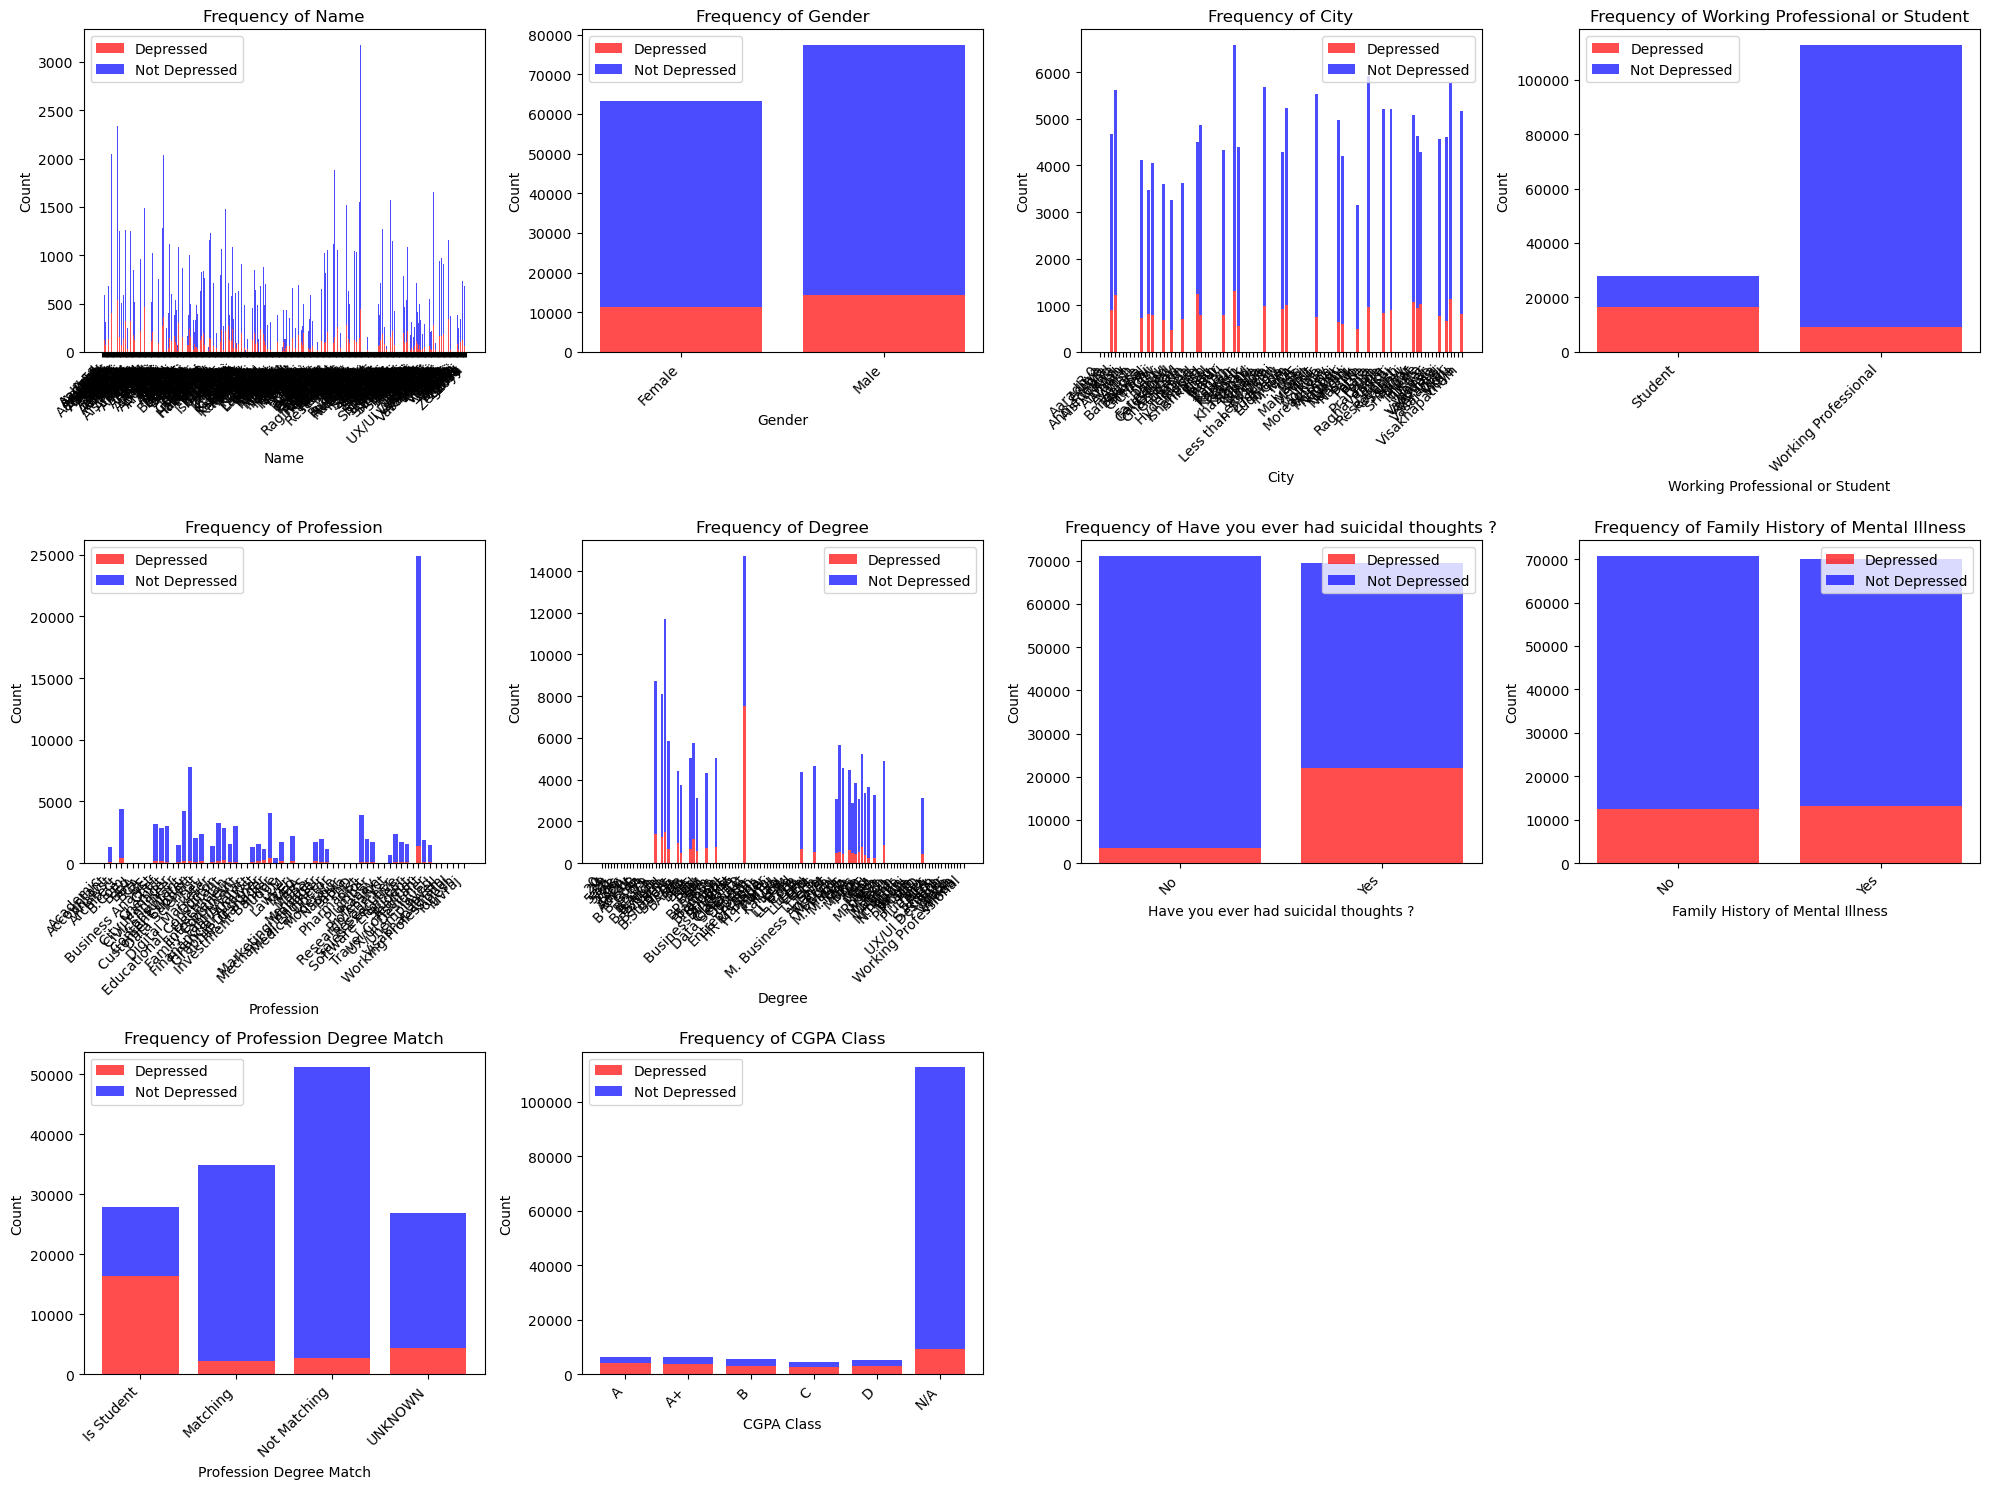

In [66]:
import math

categorical_data_df['Depression'] = processed_train_df['Depression']
num_plots = len(categorical_data_df.columns)

num_cols = 4
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

valid_axes_count = 0
for col in categorical_data_df.columns:
  if col == 'Depression':
    continue
  
  freq_table = categorical_data_df.groupby([col, 'Depression']).size().unstack(fill_value=0)

  x_positions = range(len(freq_table.index))
  axes[valid_axes_count].bar(x_positions, freq_table[1], color='red', alpha=0.7, label='Depressed')
  axes[valid_axes_count].bar(x_positions, freq_table[0], bottom=freq_table[1], color='blue', alpha=0.7, label='Not Depressed')

  axes[valid_axes_count].set_xticks(x_positions)
  axes[valid_axes_count].set_xticklabels(freq_table.index, rotation=45, ha='right')
  
  axes[valid_axes_count].set_title(f'Frequency of {col}')
  axes[valid_axes_count].set_xlabel(col)
  axes[valid_axes_count].set_ylabel('Count')
  axes[valid_axes_count].legend()
  
  valid_axes_count += 1

for j in range(valid_axes_count, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plotting Numerical Columns

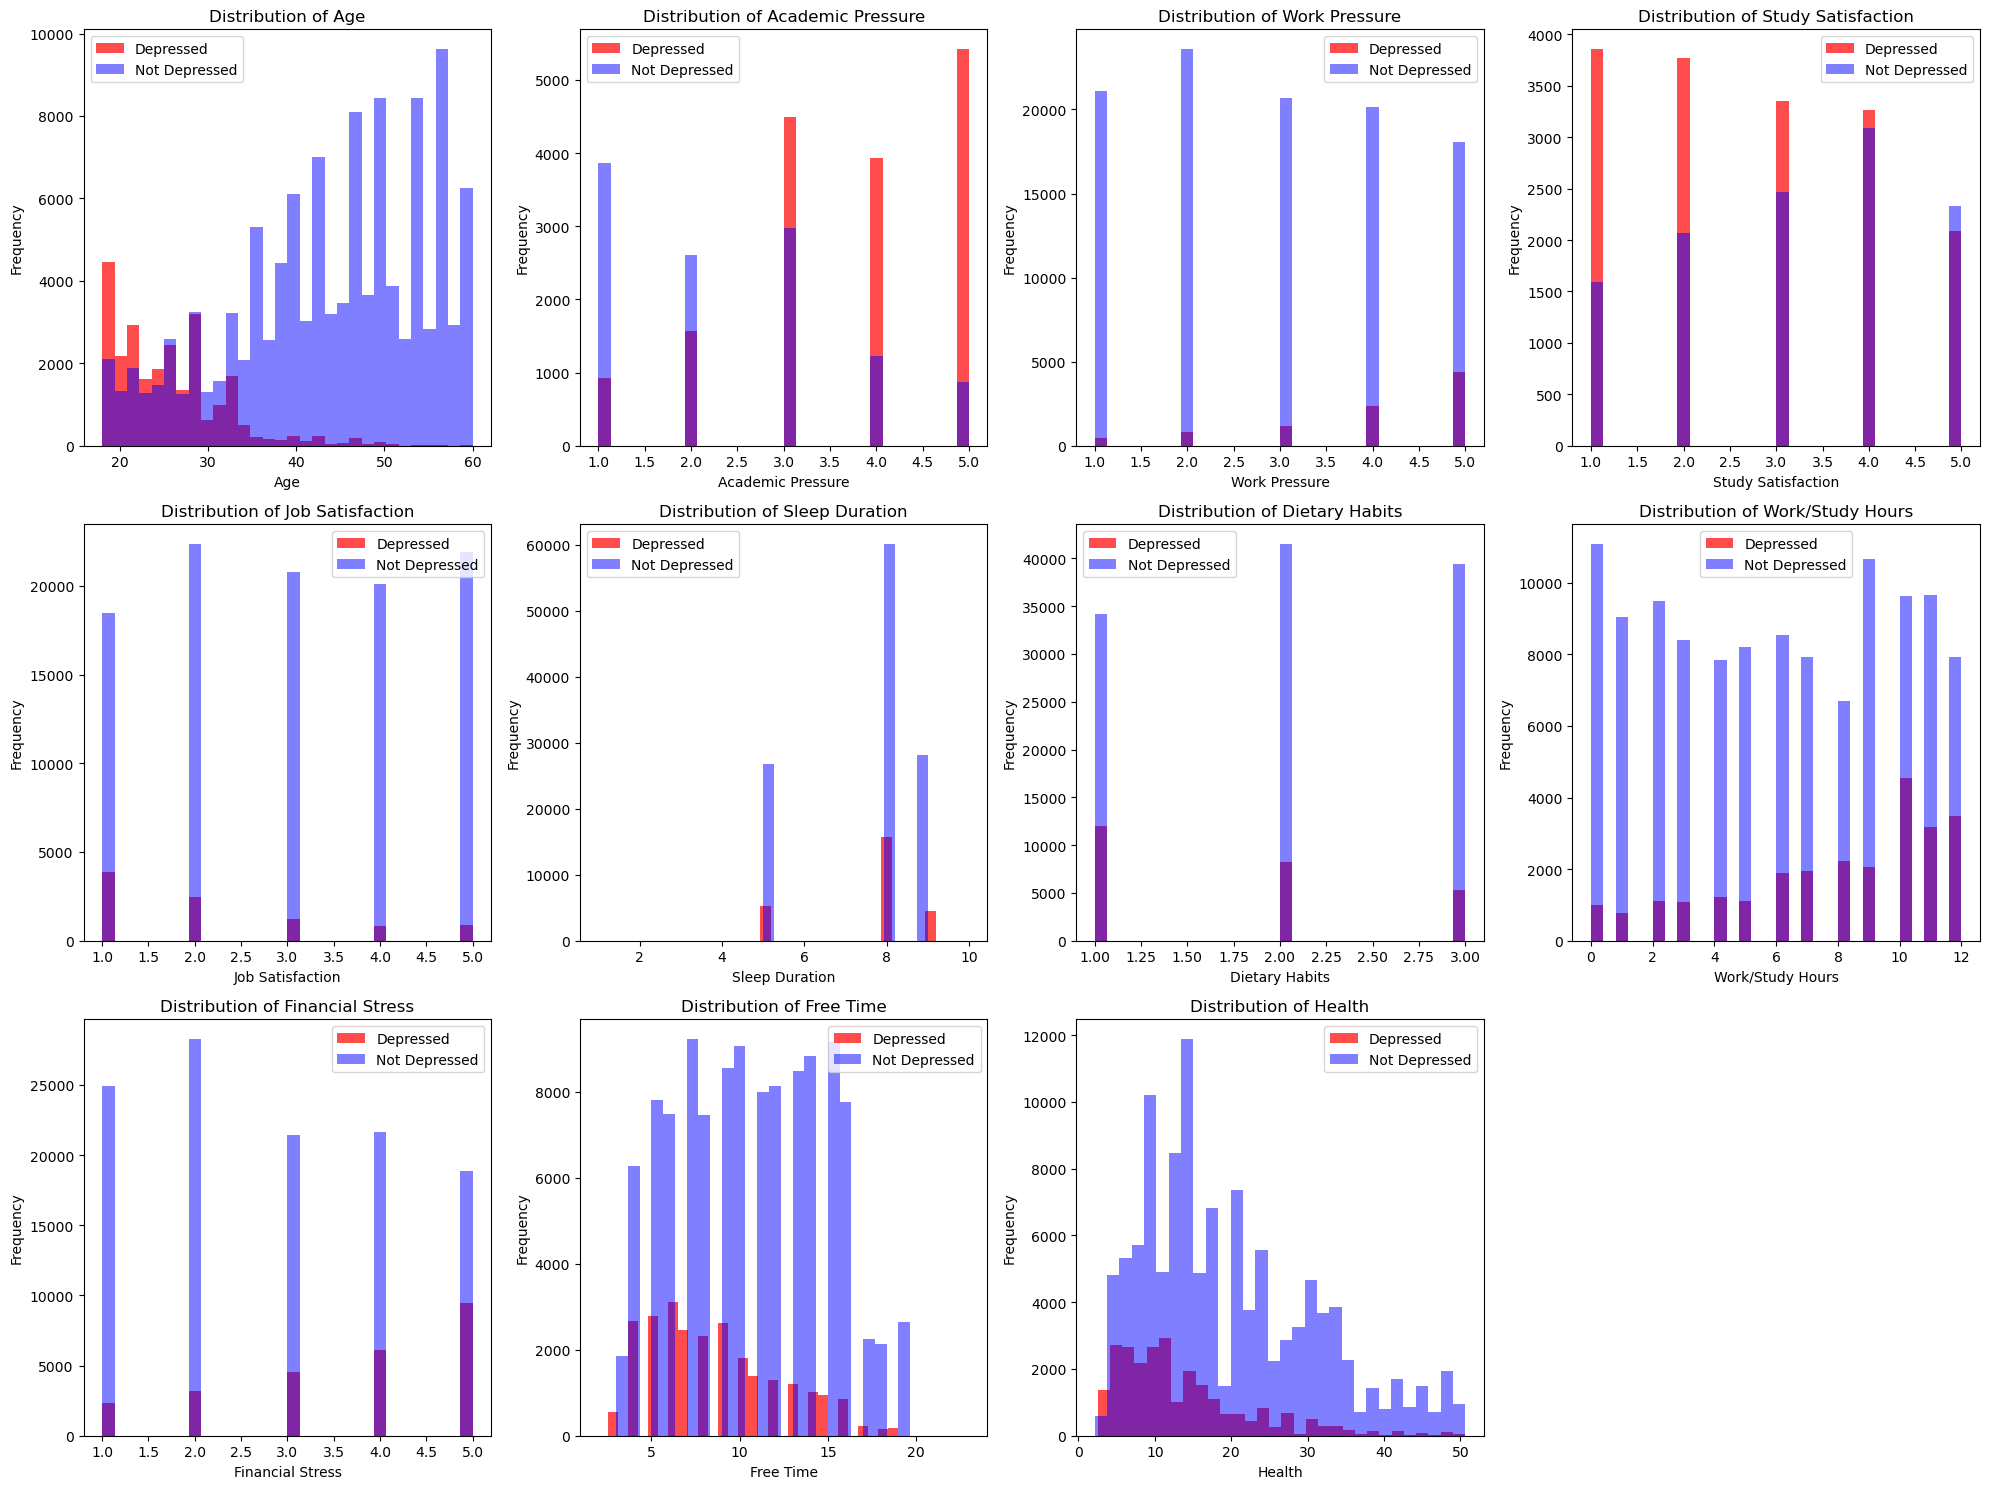

In [67]:
numeric_data_df['Depression'] = processed_train_df['Depression']

num_cols = len(numeric_data_df.columns)
num_plot_cols = 4
num_plot_rows = math.ceil(num_cols / num_plot_cols)

fig, axes = plt.subplots(num_plot_rows, num_plot_cols, figsize=(20, num_plot_rows * 5))
axes = axes.flatten()

valid_axes_count = 0

for col in numeric_data_df.columns:
  if col == 'Depression' or col == 'id':
    continue
  
  depressed = numeric_data_df[numeric_data_df['Depression'] == 1][col].dropna()
  not_depressed = numeric_data_df[numeric_data_df['Depression'] == 0][col].dropna()
  
  axes[valid_axes_count].hist(depressed, bins=30, color='red', alpha=0.7, label='Depressed')
  axes[valid_axes_count].hist(not_depressed, bins=30, color='blue', alpha=0.5, label='Not Depressed')
  
  axes[valid_axes_count].set_title(f'Distribution of {col}')
  axes[valid_axes_count].set_xlabel(col)
  axes[valid_axes_count].set_ylabel('Frequency')
  axes[valid_axes_count].legend()
  
  valid_axes_count += 1

for j in range(valid_axes_count, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# One-Hot Encoding for Categorical Data 

In [68]:
categorical_data_df.drop(columns=['Depression'], inplace=True, errors='ignore')

for col in categorical_data_df.columns:
  counts = processed_train_df[col].value_counts()
  one_hot = pd.get_dummies(processed_train_df[col], prefix=col)
  processed_train_df = pd.concat([processed_train_df, one_hot], axis=1)
  processed_train_df.drop(columns=[col], inplace=True)
  
  processed_test_df.loc[~processed_test_df[col].isin(counts.keys()), col] = counts.argmax()
  
  test_one_hot = pd.get_dummies(processed_test_df[col], prefix=col)
  processed_test_df = pd.concat([processed_test_df, test_one_hot], axis=1)
  processed_test_df.drop(columns=[col], inplace=True)
  
  for one_hot_col in one_hot.columns:
    if one_hot_col not in processed_test_df.columns:
      processed_test_df[one_hot_col] = False

/var/folders/g9/q2s64klx3nq1m_bjfv4h32j80000gn/T/ipykernel_24099/1548048714.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[one_hot_col] = False
/var/folders/g9/q2s64klx3nq1m_bjfv4h32j80000gn/T/ipykernel_24099/1548048714.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed_test_df[one_hot_col] = False
/var/folders/g9/q2s64klx3nq1m_bjfv4h32j80000gn/T/ipykernel_24099/1548048714.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

# Correlations

The new features that we created showed strong correlations, which helped improve our model.

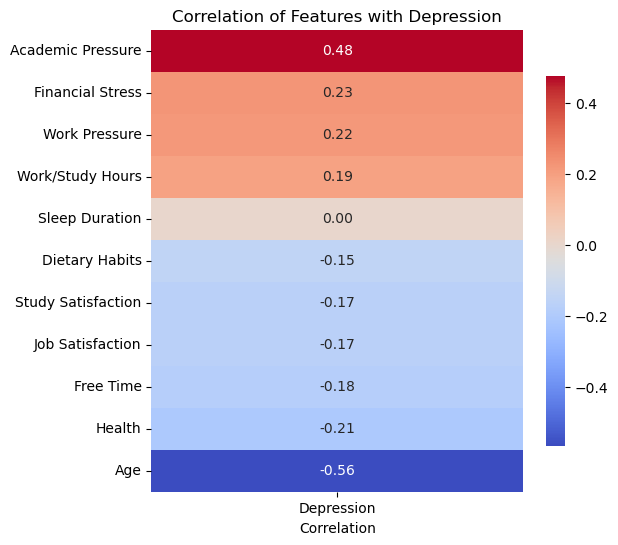

In [69]:
correlations = numeric_data_df.corr()['Depression'].drop('Depression', errors='ignore')
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.to_frame().sort_values(by='Depression', ascending=False), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Correlation of Features with Depression')
plt.xlabel('Correlation')
plt.show()

In [70]:
numeric_data_df = numeric_data_df.drop(columns=['Depression'], errors='ignore')
categorical_data_df = categorical_data_df.drop(columns=['Depression'], errors='ignore')

# Training

In [71]:
X = processed_train_df.drop('Depression', axis=1)
y = processed_train_df['Depression']

We are applying Min-Max Scaling to the numeric features in both the training and test sets to ensure they are on the same scale. This helps improve the performance and stability of our models.

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train[numeric_data_df.columns] = scaler.fit_transform(X_train[numeric_data_df.columns])
X_test[numeric_data_df.columns] = scaler.transform(X_test[numeric_data_df.columns])

processed_test_df[numeric_data_df.columns] = scaler.transform(processed_test_df[numeric_data_df.columns])

The objective function for hyperparameter optimization using **Optuna** is defined to set up a **CatBoost Classifier**. It utilizes **Stratified K-Fold Cross Validation** to evaluate different hyperparameters based on the **Logloss** evaluation metric, as this is a classification problem. The function returns the mean accuracy across all folds, and **Optuna** aims to maximize this value.

In [73]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

def objective(trial):
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'depth': trial.suggest_int('depth', 1, 6),
    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 15.0, log=True),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    'eval_metric': 'Logloss',
    'loss_function': 'Logloss',
    'verbose': 0,
  }
  
  model = CatBoostClassifier(**params, random_state=42)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
  scores = []
  
  for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    scores.append(accuracy_score(y_val_fold, y_pred))
  
  return np.mean(scores)

The code checks for previously saved hyperparameters, if not found, it runs **Optuna** optimization, saves the best parameters, and proceeds.

In [74]:
import os
import pickle

if not os.path.exists('best_params.pkl'):
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=20) 

  print("Best Hyperparameters:", study.best_params)
  print("Best Accuracy:", study.best_value)

  best_params = study.best_params
else:
  with open('best_params.pkl', 'rb') as file:
    best_params = pickle.load(file)

cat = CatBoostClassifier(**best_params, random_state=42, verbose=0)

cat.fit(X_train, y_train)

[I 2024-11-27 18:47:18,119] A new study created in memory with name: no-name-fd32cb32-06ce-4d73-8931-8cf08bd5d8e8
[I 2024-11-27 18:47:40,073] Trial 0 finished with value: 0.9395255863539447 and parameters: {'iterations': 720, 'depth': 1, 'learning_rate': 0.21905456740294943, 'l2_leaf_reg': 4.674918564867292, 'border_count': 145, 'random_strength': 1.8243364136919413, 'bagging_temperature': 0.9417575332918965}. Best is trial 0 with value: 0.9395255863539447.
[I 2024-11-27 18:48:16,753] Trial 1 finished with value: 0.9396766169154229 and parameters: {'iterations': 915, 'depth': 4, 'learning_rate': 0.13068346333529174, 'l2_leaf_reg': 0.4198470904946561, 'border_count': 48, 'random_strength': 7.776951779533109, 'bagging_temperature': 0.17045116150290984}. Best is trial 1 with value: 0.9396766169154229.
[I 2024-11-27 18:48:50,282] Trial 2 finished with value: 0.9396499644633973 and parameters: {'iterations': 935, 'depth': 2, 'learning_rate': 0.2412943919860741, 'l2_leaf_reg': 0.413701669780

Best Hyperparameters: {'iterations': 782, 'depth': 6, 'learning_rate': 0.07720887996511758, 'l2_leaf_reg': 1.732989676599524, 'border_count': 93, 'random_strength': 0.19642050894150653, 'bagging_temperature': 0.6826999639259455}
Best Accuracy: 0.9398276474769013


In [75]:
with open('best_params.pkl', 'wb') as file:
  pickle.dump(best_params, file)

In [76]:
y_pred = cat.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9398720682302771


# Evaluation

This code provides a set of functions to evaluate the performance of a classification model by calculating key metrics (such as accuracy, precision, recall, F1 score) and generating visualizations like confusion matrices and ROC curves. It helps assess the model’s effectiveness and make informed decisions about its performance, feel free to use it in your future notebooks!

In [77]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def print_evaluations_metrics(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)

  recall = recall_score(y_test, y_pred)

  precision = precision_score(y_test, y_pred)

  f1 = f1_score(y_test, y_pred)

  print("Accuracy is ", accuracy)
  print('Recall is', recall)
  print('Precision is', precision)
  print('F1 score is', f1)

def print_classification_report(y_test, y_pred):
  report = classification_report(y_test, y_pred)
  print(report)

def plot_confusion_matrix(y_test, y_pred):
  confusion = confusion_matrix(y_test, y_pred)

  df_cm = pd.DataFrame(confusion, index = ['0', '1'], columns = ['0', '1'])
  plt.figure(figsize = (5.5,4))
  sns.heatmap(df_cm, fmt='g',annot=True)
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

def plot_auc_and_roc_curve(y_test, y_pred):
  fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

  roc_auc_lr = auc(fpr_lr, tpr_lr)
  print('area under roc is', roc_auc_lr)

  plt.figure()
  plt.xlim([-0.01, 1.00])
  plt.ylim([-0.01, 1.01])
  plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.title('ROC curve ', fontsize=16)
  plt.legend(loc='lower right', fontsize=13)
  plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
  plt.show()

def evaluate(y_test, y_pred, print_class_report = True, plot_conf_matrix=True, plot_auc_and_roc = True):
  print_evaluations_metrics(y_test, y_pred)
  if (print_class_report):
    print_classification_report(y_test, y_pred)
  if (plot_conf_matrix):
    plot_confusion_matrix(y_test, y_pred)
  if (plot_auc_and_roc):
    plot_auc_and_roc_curve(y_test, y_pred)

Accuracy is  0.9398720682302771
Recall is 0.8226620100892511
Precision is 0.8449581506576325
F1 score is 0.8336610302791978
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.82      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140

area under roc is 0.8944076604000593


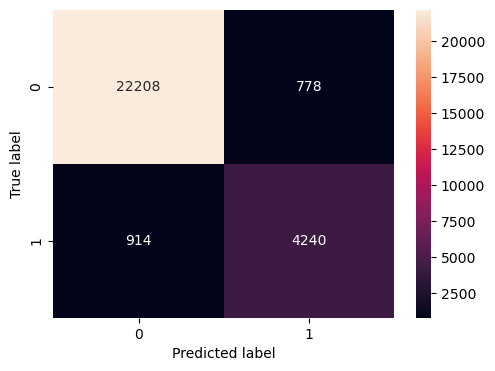

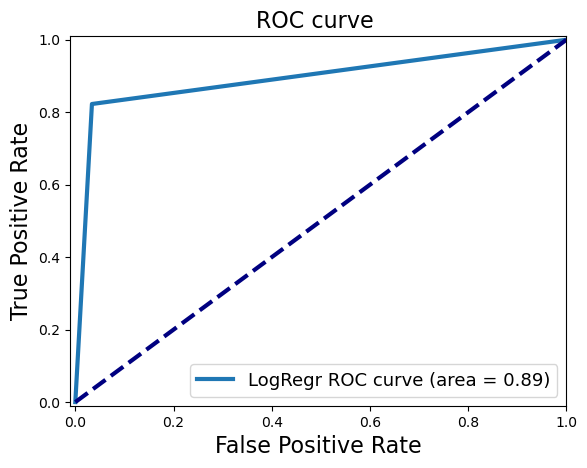

In [78]:
evaluate(y_test, y_pred)

This code generates and visualizes confusion matrices for two groups: **students** and **working professionals**. Due to the lack of enough **students** in the dataset, we separated them to evaluate the model’s accuracy specifically on this group. The test set is filtered to isolate the students and working professionals, and confusion matrices are computed for each group separately. The results are then plotted side by side, displaying the model’s performance in both groups.

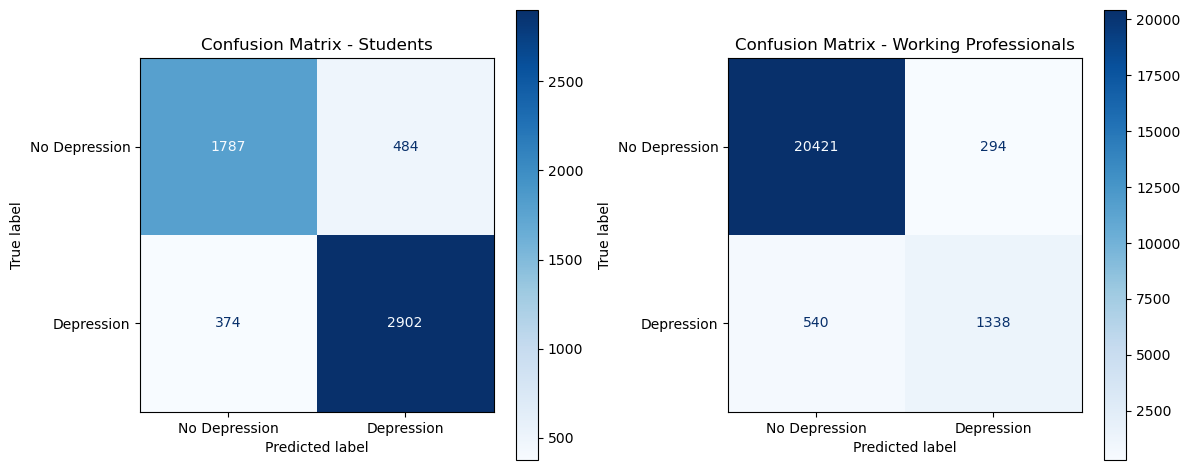

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

student_indices = X_test['Working Professional or Student_Student'] == 1
y_test_students = y_test[student_indices]
y_pred_students = y_pred[student_indices]

working_indices = X_test['Working Professional or Student_Working Professional'] == 1
y_test_working = y_test[working_indices]
y_pred_working = y_pred[working_indices]

cm_students = confusion_matrix(y_test_students, y_pred_students)
cm_working = confusion_matrix(y_test_working, y_pred_working)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_students = ConfusionMatrixDisplay(confusion_matrix=cm_students, display_labels=['No Depression', 'Depression'])
disp_students.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='d')
axes[0].set_title('Confusion Matrix - Students')

disp_working = ConfusionMatrixDisplay(confusion_matrix=cm_working, display_labels=['No Depression', 'Depression'])
disp_working.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='d')
axes[1].set_title('Confusion Matrix - Working Professionals')

plt.tight_layout()
plt.show()

# Submission

In [80]:
id_df = pd.read_csv(test_path)['id']

In [81]:
test_preds = cat.predict(processed_test_df)
output = pd.DataFrame({'id': id_df, 'Depression': test_preds})
output.to_csv(f'./submissions/{test_accuracy}.csv', index=False)

Here we are storing the ```best_params``` locally in a **.csv** file.

In [82]:
score = pd.DataFrame([{**best_params, 'score': test_accuracy}])

csv_file_path = 'params_output.csv'

score.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)

In [83]:
best_params = {
  'iterations': 746,
  'depth': 2,
  'learning_rate': 0.11918327976253101,
  'l2_leaf_reg': 0.16082171219746763,
  'border_count': 34,
  'random_strength': 2.095071850858897,
  'bagging_temperature': 0.9988961269189247
}